### Model Portfolio Max Sharpe Ratio

In [9]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from dotenv import load_dotenv
import os

# -----------------------------
# Setup & MT5 initialization
# -----------------------------
load_dotenv()
login = int(os.getenv("ACG_MT5_LOGIN"))
password = os.getenv("ACG_MT5_PASSWORD")
server = os.getenv("ACG_MT5_SERVER")

if not mt5.initialize(login=login, password=password, server=server):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# -----------------------------
# Config
# -----------------------------
risk_free_rate = 0.0

# FX pairs needed to convert index returns to USD
fx_map = {
    "GER30.pro": "EURUSD.pro",
    "JPN225.pro": "USDJPY.pro",   # flip sign
    "HK50.pro": "USDHKD.pro",     # flip sign
    "UK100.pro": "GBPUSD.pro",
    "EUSTX50.pro": "EURUSD.pro"
}

# -----------------------------
# Helpers
# -----------------------------
def fetch_mt5_data(symbol, days=60):
    utc_from = pd.Timestamp.now() - pd.Timedelta(days=days)
    rates = mt5.copy_rates_from(symbol, mt5.TIMEFRAME_D1, utc_from, days)
    if rates is None:
        raise ValueError(f"Failed to fetch data for {symbol}")
    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")
    df.set_index("time", inplace=True)
    return df

def calculate_log_returns(prices: pd.Series) -> pd.Series:
    return np.log(prices / prices.shift(1)).dropna()

# -----------------------------
# Load expected returns
# -----------------------------
# expected_return_acg.csv:  asset \t expected_return
expected_returns_df = pd.read_csv("expected_return_acg.csv", sep="\t", header=None)
expected_returns_dict = dict(zip(expected_returns_df[0], expected_returns_df[1]))

symbols = list(expected_returns_dict.keys())

# -----------------------------
# Fetch price data for assets
# -----------------------------
data = {symbol: fetch_mt5_data(symbol) for symbol in symbols}

# -----------------------------
# Fetch FX data and compute FX log returns
# -----------------------------
fx_symbols = set(fx_map[s] for s in symbols if s in fx_map)
fx_data = {fx: fetch_mt5_data(fx) for fx in fx_symbols}

fx_returns = {}
for fx, df_fx in fx_data.items():
    lr = calculate_log_returns(df_fx["close"])

    # If pair is quoted as USDXXX (e.g., USDJPY, USDHKD), flip sign to get XXXUSD log return
    if fx.startswith("USD"):
        lr = -lr  # log(1/x) = -log(x)

    fx_returns[fx] = lr

# -----------------------------
# Compute USD-adjusted log returns for all assets
# -----------------------------
asset_returns = {}

for symbol in symbols:
    idx_lr = calculate_log_returns(data[symbol]["close"])

    if symbol in fx_map:
        fx_symbol = fx_map[symbol]
        fx_lr = fx_returns[fx_symbol]

        # Align index and FX by date
        combined = pd.concat([idx_lr, fx_lr], axis=1, join="inner")
        combined.columns = ["idx", "fx"]

        # USD-adjusted return: r_usd = r_index_local + r_fx
        asset_returns[symbol] = combined["idx"] + combined["fx"]
    else:
        # Already in USD terms
        asset_returns[symbol] = idx_lr

# -----------------------------
# Build aligned returns matrix
# -----------------------------
returns = pd.DataFrame(asset_returns).dropna(how="any")

# -----------------------------
# Covariance matrix (daily, log returns)
# -----------------------------
cov_matrix = returns.cov()

# Expected daily returns vector (assumed to be in USD terms already)
expected_returns = np.array([expected_returns_dict[symbol] for symbol in symbols])

# -----------------------------
# Max Sharpe optimization
# -----------------------------
def max_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(expected_returns)

    def neg_sharpe(weights):
        port_ret = np.dot(weights, expected_returns)
        port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(port_ret - risk_free_rate) / port_vol

    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    bounds = [(-1, 1)] * num_assets  # allow shorting; change to (0,1) for long-only
    init_guess = np.ones(num_assets) / num_assets

    result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    weights = result.x
    daily_ret = np.dot(weights, expected_returns)
    daily_vol = np.sqrt(weights.T @ cov_matrix @ weights)

    return weights, daily_ret, daily_vol

# -----------------------------
# Run optimization
# -----------------------------
weights, daily_port_return, daily_port_vol = max_sharpe_ratio(
    expected_returns, cov_matrix, risk_free_rate=risk_free_rate
)

# -----------------------------
# Export optimal weights
# -----------------------------
weights_df = pd.DataFrame({
    "Symbol": symbols,
    "Weight": weights
})
weights_df.to_csv("acg_optimal_portfolio_weights.csv", index=False)
print("\nWeights exported to acg_optimal_portfolio_weights.csv")

# -----------------------------
# Annualized statistics (using daily log returns)
# -----------------------------
annual_port_return = (1 + daily_port_return)**252 - 1
annual_port_vol = daily_port_vol * np.sqrt(252)
annual_sharpe = (annual_port_return - risk_free_rate) / annual_port_vol

# -----------------------------
# Output
# -----------------------------
print("\nOptimal Portfolio Weights:")
for symbol, weight in zip(symbols, weights):
    print(f"{symbol}: {weight:.4f}")

print("\n--- Portfolio Statistics ---")
print(f"Daily Portfolio Return: {daily_port_return:.4%}")
print(f"Annualized Portfolio Return: {annual_port_return:.4%}")
print(f"Daily Portfolio Volatility: {daily_port_vol:.4%}")
print(f"Annualized Portfolio Volatility: {annual_port_vol:.4%}")
print(f"Annualized Sharpe Ratio: {annual_sharpe:.2f}")

# -----------------------------
# Shutdown MT5
# -----------------------------
mt5.shutdown()


Weights exported to acg_optimal_portfolio_weights.csv

Optimal Portfolio Weights:
AUDUSD.pro: 0.4070
EURUSD.pro: 0.1227
GBPUSD.pro: -0.0151
NZDUSD.pro: 0.0383
USDJPY.pro: 0.5683
USDCHF.pro: -0.4468
USDCAD.pro: 0.4119
XAGUSD.pro: 0.0397
XAUUSD.pro: -0.0433
USOIL.pro: 0.1646
UKOIL.pro: -0.2508
US500.pro: 0.2446
US30.pro: 0.0672
NAS100.pro: -0.0117
GER30.pro: -0.2091
JPN225.pro: -0.1900
HK50.pro: -0.1042
UK100.pro: -0.0581
EUSTX50.pro: 0.2647

--- Portfolio Statistics ---
Daily Portfolio Return: 1.4142%
Annualized Portfolio Return: 3342.5177%
Daily Portfolio Volatility: 0.1800%
Annualized Portfolio Volatility: 2.8568%
Annualized Sharpe Ratio: 1170.02


True

### Volatility Forecast EWMA

In [2]:
import pandas as pd
import numpy as np

# --- RAW VOLATILITY (standard deviation) ---
asset_daily_vol = returns.std()

print("\n--- Raw Daily Volatilities (Std Dev) ---")
for symbol, vol in zip(symbols, asset_daily_vol):
    print(f"{symbol}: {vol:.2%}")

# --- EWMA VOLATILITY (RiskMetrics) ---
lambda_ = 0.94  # decay factor

# EWMA variance formula applied per asset
ewma_var = returns.pow(2).ewm(alpha=1 - lambda_).mean()
ewma_vol = np.sqrt(ewma_var)

# Last EWMA volatility value per asset
asset_ewma_vol = ewma_vol.tail(1).T.iloc[:, 0]

print("\n--- EWMA Daily Volatilities (λ = 0.94) ---")
for symbol, vol in zip(symbols, asset_ewma_vol):
    print(f"{symbol}: {vol:.2%}")

# --- COMPARISON TABLE ---
comparison_df = pd.DataFrame({
    "raw_vol": asset_daily_vol,
    "ewma_vol": asset_ewma_vol
})

print("\n--- Raw vs EWMA Volatility Comparison ---")
print(comparison_df.map(lambda x: f"{x:.2%}"))

# --- EXPORT TO CSV ---
comparison_df.to_csv(
    "acg_asset_vol_comparison.csv",
    sep="\t",
    header=True,
    index=True
)


--- Raw Daily Volatilities (Std Dev) ---
AUDUSD.pro: 0.44%
EURUSD.pro: 0.38%
GBPUSD.pro: 0.38%
NZDUSD.pro: 0.46%
USDJPY.pro: 0.53%
USDCHF.pro: 0.42%
USDCAD.pro: 0.24%
XAGUSD.pro: 1.94%
XAUUSD.pro: 1.37%
USOIL.pro: 1.68%
UKOIL.pro: 1.55%
US500.pro: 0.75%
US30.pro: 0.69%
NAS100.pro: 1.02%
GER30.pro: 0.71%
JPN225.pro: 1.51%
HK50.pro: 1.43%
UK100.pro: 0.62%
EUSTX50.pro: 0.72%

--- EWMA Daily Volatilities (λ = 0.94) ---
AUDUSD.pro: 0.42%
EURUSD.pro: 0.32%
GBPUSD.pro: 0.33%
NZDUSD.pro: 0.36%
USDJPY.pro: 0.56%
USDCHF.pro: 0.37%
USDCAD.pro: 0.21%
XAGUSD.pro: 2.48%
XAUUSD.pro: 1.87%
USOIL.pro: 1.86%
UKOIL.pro: 1.74%
US500.pro: 0.87%
US30.pro: 0.75%
NAS100.pro: 1.19%
GER30.pro: 0.65%
JPN225.pro: 1.67%
HK50.pro: 1.52%
UK100.pro: 0.58%
EUSTX50.pro: 0.71%

--- Raw vs EWMA Volatility Comparison ---
            raw_vol ewma_vol
AUDUSD.pro    0.44%    0.42%
EURUSD.pro    0.38%    0.32%
GBPUSD.pro    0.38%    0.33%
NZDUSD.pro    0.46%    0.36%
USDJPY.pro    0.53%    0.56%
USDCHF.pro    0.42%    0.37%


### Correlation Past 60 Trading Days

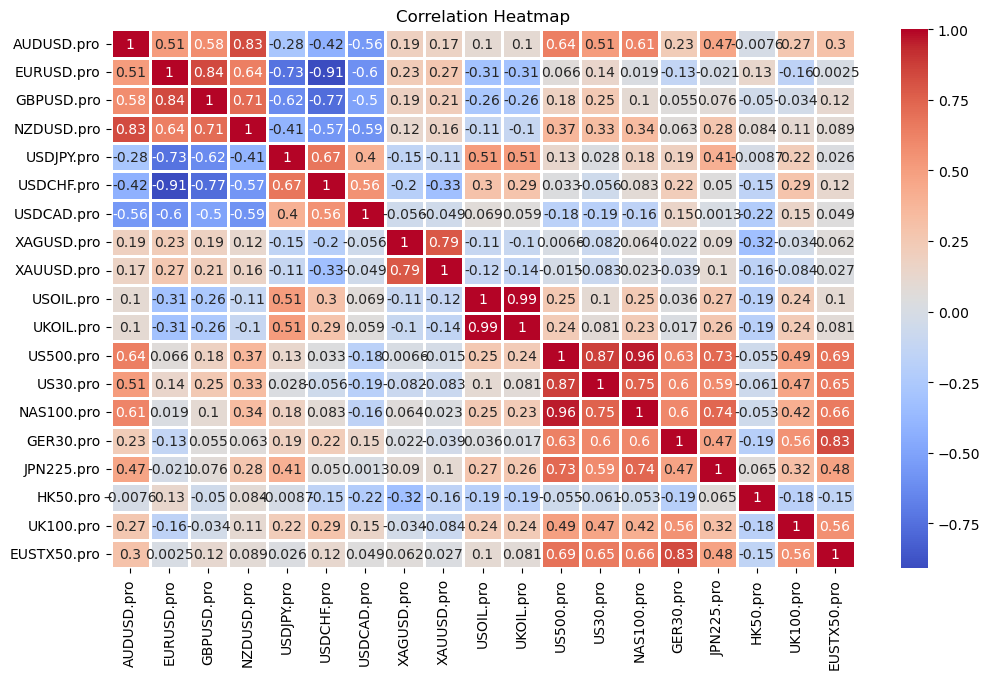

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = returns.corr()

plt.figure(figsize=(12, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.8)
plt.title("Correlation Heatmap")
plt.show()

### Volatility Targeted Weights

In [15]:
import pandas as pd
import numpy as np

# --- Load weights from comma-separated file ---
weights_df = pd.read_csv(
    "acg_actual_weights.csv",
    header=None,
    engine="python",
    encoding="utf-8-sig"
)

weights_df.columns = ["asset", "weight"]

# Align weights to returns.columns order
weights_df = weights_df.set_index("asset").reindex(returns.columns)

# Extract weight vector
weights = weights_df["weight"].values

print("Loaded weights (aligned):")
print(weights)
print("\nAsset order:")
print(list(returns.columns))

# --- Portfolio calculations ---
cov_matrix = returns.cov()

# Daily volatility
portfolio_volatility = np.sqrt(weights.T @ cov_matrix.values @ weights)
annualized_volatility = portfolio_volatility * np.sqrt(252)

print(f"\n--- ORIGINAL PORTFOLIO ---")
print(f"Daily Portfolio Volatility: {portfolio_volatility:0.2%}")
print(f"Annualized Portfolio Volatility: {annualized_volatility:0.2%}")

# Historical return (not used for optimization)
portfolio_daily_returns = returns @ weights
avg_daily_return = portfolio_daily_returns.mean()
annualized_return = avg_daily_return * 252

sharpe_ratio = annualized_return / annualized_volatility

print(f"Average Daily Portfolio Return: {avg_daily_return:0.2%}")
print(f"Annualized Portfolio Return: {annualized_return:0.2%}")
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")

# --- SCALE PORTFOLIO TO TARGET VOLATILITY ---
target_vol = 0.10   # 10% annual volatility

scale_factor = target_vol / annualized_volatility
scaled_weights = weights * scale_factor

# Recompute volatility after scaling
scaled_daily_vol = np.sqrt(scaled_weights.T @ cov_matrix.values @ scaled_weights)
scaled_annual_vol = scaled_daily_vol * np.sqrt(252)

print(f"\n--- SCALED PORTFOLIO (Target Vol = 10%) ---")
print(f"Scale Factor: {scale_factor:.4f}")
print(f"Scaled Annual Volatility: {scaled_annual_vol:0.2%}")

print("\nScaled Weights:")
for asset, w in zip(returns.columns, scaled_weights):
    print(f"{asset}: {w:.6f}")

Loaded weights (aligned):
[ 0.15  0.32 -0.05  0.06  0.49 -0.11  0.2   0.04  0.04 -0.07 -0.13  0.27
  0.07  0.09 -0.11 -0.12 -0.02 -0.03  0.16]

Asset order:
['AUDUSD.pro', 'EURUSD.pro', 'GBPUSD.pro', 'NZDUSD.pro', 'USDJPY.pro', 'USDCHF.pro', 'USDCAD.pro', 'XAGUSD.pro', 'XAUUSD.pro', 'USOIL.pro', 'UKOIL.pro', 'US500.pro', 'US30.pro', 'NAS100.pro', 'GER30.pro', 'JPN225.pro', 'HK50.pro', 'UK100.pro', 'EUSTX50.pro']

--- ORIGINAL PORTFOLIO ---
Daily Portfolio Volatility: 0.36%
Annualized Portfolio Volatility: 5.74%
Average Daily Portfolio Return: 0.13%
Annualized Portfolio Return: 31.52%
Sharpe Ratio (annualized): 5.49

--- SCALED PORTFOLIO (Target Vol = 10%) ---
Scale Factor: 1.7423
Scaled Annual Volatility: 10.00%

Scaled Weights:
AUDUSD.pro: 0.261345
EURUSD.pro: 0.557535
GBPUSD.pro: -0.087115
NZDUSD.pro: 0.104538
USDJPY.pro: 0.853726
USDCHF.pro: -0.191653
USDCAD.pro: 0.348460
XAGUSD.pro: 0.069692
XAUUSD.pro: 0.069692
USOIL.pro: -0.121961
UKOIL.pro: -0.226499
US500.pro: 0.470420
US30.pro

In [4]:
# --- EXPORT SCALED WEIGHTS TO CSV ---

scaled_df = pd.DataFrame({
    "asset": returns.columns,
    "scaled_weight": scaled_weights
})

scaled_df.to_csv("acg_scaled_weights.csv", index=False)
print("\nScaled weights exported to acg_scaled_weights.csv")


Scaled weights exported to acg_scaled_weights.csv


### Fetch Latest Price

In [3]:
import pandas as pd
import MetaTrader5 as mt5

# -----------------------------------------------------------
# 1. LOAD EXPECTED RETURNS FROM CSV (NO HEADER)
# -----------------------------------------------------------

expected_returns_df = pd.read_csv("expected_return_acg.csv", sep="\t", header=None)
expected_returns_dict = dict(zip(expected_returns_df[0], expected_returns_df[1]))

# -----------------------------------------------------------
# 2. INITIALIZE MT5
# -----------------------------------------------------------

# Initialize MT5 connection
from dotenv import load_dotenv
import os

load_dotenv()

login = int(os.getenv("ACG_MT5_LOGIN"))
password = os.getenv("ACG_MT5_PASSWORD")
server = os.getenv("ACG_MT5_SERVER")

if not mt5.initialize(login=login, password=password, server=server):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# -----------------------------------------------------------
# 3. FETCH LATEST PRICES
# -----------------------------------------------------------

latest_prices = {}

for asset in expected_returns_dict.keys():

    mt5.symbol_select(asset, True)
    tick = mt5.symbol_info_tick(asset)

    if tick is None:
        latest_prices[asset] = None
        print(f"Failed to fetch price for {asset}")
    else:
        latest_prices[asset] = tick.bid

# -----------------------------------------------------------
# 4. BUILD DATAFRAME
# -----------------------------------------------------------

df_prices = pd.DataFrame({
    "Asset": list(latest_prices.keys()),
    "LatestPrice": list(latest_prices.values()),
})

print(df_prices)

# -----------------------------------------------------------
# 5. SAVE TO CSV
# -----------------------------------------------------------

df_prices.to_csv("latest_prices_acg.csv", index=False)

# -----------------------------------------------------------
# 6. SHUT DOWN MT5
# -----------------------------------------------------------

mt5.shutdown()

          Asset  LatestPrice
0    AUDUSD.pro      0.66931
1    EURUSD.pro      1.17715
2    GBPUSD.pro      1.35026
3    NZDUSD.pro      0.58055
4    USDJPY.pro    156.24500
5    USDCHF.pro      0.78894
6    USDCAD.pro      1.36896
7    XAGUSD.pro     72.71300
8    XAUUSD.pro   4335.82000
9     USOIL.pro     57.60500
10    UKOIL.pro     61.12600
11    US500.pro   6910.61000
12     US30.pro  48515.72000
13   NAS100.pro  25529.74000
14    GER30.pro  24406.97000
15   JPN225.pro  50456.51000
16     HK50.pro  25627.24000
17    UK100.pro   9893.11000
18  EUSTX50.pro   5763.35000


True